## Plots of seasonal variations in SST and surface flux, their correlation max time, and MLD

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44455/status,
Dashboard: /proxy/44455/status,Workers: 8
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38525,Workers: 8
Dashboard: /proxy/44455/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:33147,Total threads: 1
Dashboard: /proxy/43815/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:38883,


In [4]:
# files:
base = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF sc data
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/output096-105_mean/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_sc = xr.open_mfdataset(base_msc+'ocean_month.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_sc = xr.open_mfdataset(base_msc+'ocean_heat.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_sc = xr.open_mfdataset(base_msc+'ocean_wmass.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})
fwmass_mix_sc = xr.open_mfdataset(base_msc+'ocean_wmass_diff_cbt.ncea.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})
# load RYF monthly data for 1 year
base_msc = '/g/data/hh5/tmp/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


In [5]:
# Group SF and MX terms for sc data:

obj, obj2 = xr.broadcast(fheat_sc.sfc_hflux_pme,fheat_sc.temp_vdiffuse_sbc)
sfc_hflux_pme_sc = obj.where(fheat_sc.st_ocean==fheat_sc.st_ocean[0],other=0.)
fheat_sc["sfc_hflux_pme_sc"]=sfc_hflux_pme_sc
fheat_sc["MX_cv"] = fheat_sc.temp_vdiffuse_diff_cbt + \
                      fheat_sc.temp_nonlocal_KPP 
fheat_sc["SF_cv"] = fheat_sc.temp_vdiffuse_sbc + \
                      fheat_sc.sw_heat + \
                      fheat_sc.frazil_3d + \
                      sfc_hflux_pme_sc 
#                      fheat_sc.temp_rivermix
fwmass_sc["MX_cv"] = fwmass_sc.temp_vdiffuse_diff_cbt_on_nrho + \
                      fwmass_sc.temp_nonlocal_KPP_on_nrho 
fwmass_sc["SF_cv"] = fwmass_sc.temp_vdiffuse_sbc_on_nrho + \
                      fwmass_sc.sw_heat_on_nrho + \
                      fwmass_sc.sfc_hflux_pme_on_nrho + \
                      fwmass_sc.frazil_on_nrho
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)
fheat_mean["sfc_hflux_pme_mean"]=sfc_hflux_pme_mean
fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP


In [6]:
# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
# gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
#                              "y":{"center":"yt_ocean","right":"yu_ocean"},
#                              "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

In [7]:
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend')
dxt = grid2.diff(fgrd.xu_ocean,'x',boundary='extend')

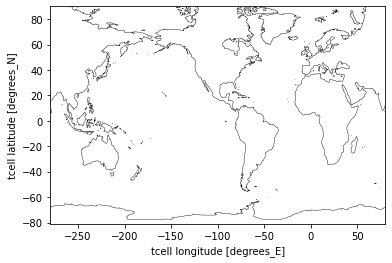

In [8]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

Max - min over seasonal cycle

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice 

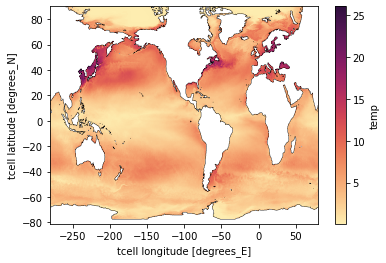

In [9]:
(fmonth_sc.temp.isel(st_ocean = 0).max('time')-fmonth_sc.temp.isel(st_ocean = 0).min('time')).plot(cmap = cm.cm.matter)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

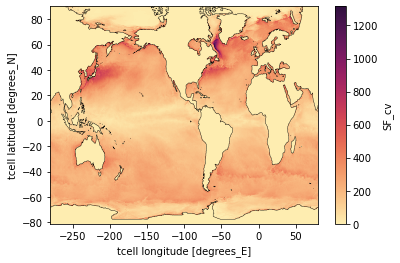

In [10]:
(fheat_sc.SF_cv.sum('st_ocean').max('time')-fheat_sc.SF_cv.sum('st_ocean').min('time')).plot(cmap = cm.cm.matter)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

Correlation between values

In [11]:
corr = xr.corr(fheat_sc.SF_cv.sum('st_ocean'),fmonth_sc.temp.isel(st_ocean = 0),dim = 'time')

In [12]:
corr.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/a

<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    st_ocean  float64 1.152

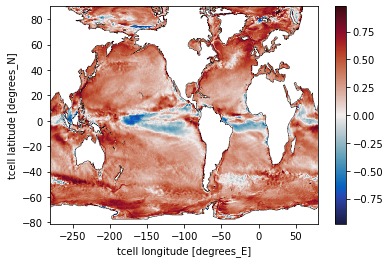

In [13]:
(corr).plot(cmap = cm.cm.balance)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

In [14]:
corr_lag = xr.zeros_like(fmonth_sc.temp.isel(st_ocean = 0))
corr_lag = corr_lag.assign_coords({'time':np.arange(12)})
for i in np.arange(len(fheat_sc.time)):
    corr_i = xr.corr(fheat_sc.SF_cv.sum('st_ocean').roll(time = i, roll_coords = False) ,fmonth_sc.temp.isel(st_ocean = 0),dim = 'time')
    corr_i.load()
    corr_lag[i,...]=corr_i
corr_lag

,Array,Chunk
Bytes,71.19 MiB,60.75 kiB
Shape,"(12, 1080, 1440)","(1, 108, 144)"
Count,13 Graph Layers,1200 Chunks
Type,float32,numpy.ndarray


Text(0, 0.5, 'Latitude ($^\\circ$N)')

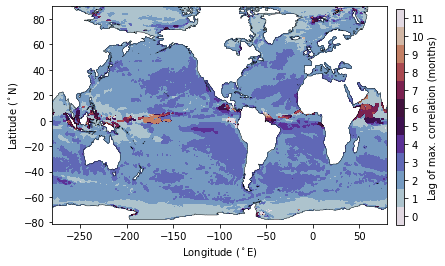

In [15]:
fig,ax = plt.subplots()
p1 = corr_lag.idxmax('time').plot.contourf(cmap = 'twilight', levels = np.arange(13)-0.5, add_colorbar = False)
ax_cb = plt.axes([0.92,0.12,0.02,0.75])
cb = plt.colorbar(p1, cax = ax_cb, label = 'Lag of max. correlation (months)',ticks = np.arange(12))
mask.plot.contour(ax = ax, levels = [0.5],linewidths = 0.4, colors = 'k')

ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')


anomalies instead?? (makes no difference)

In [16]:
corr_lag2 = xr.zeros_like(fmonth_sc.temp.isel(st_ocean = 0))
corr_lag2 = corr_lag2.assign_coords({'time':np.arange(12)})
for i in np.arange(len(fheat_sc.time)):
    corr_i = xr.corr(fheat_sc.SF_cv.sum('st_ocean').roll(time = i, roll_coords = False) -fheat_mean.SF_cv.sum('st_ocean'),fmonth_sc.temp.isel(st_ocean = 0)-fmonth_mean.temp.isel(st_ocean = 0),dim = 'time')
    corr_i.load()
    corr_lag2[i,...]=corr_i
corr_lag2

,Array,Chunk
Bytes,71.19 MiB,60.75 kiB
Shape,"(12, 1080, 1440)","(1, 108, 144)"
Count,13 Graph Layers,1200 Chunks
Type,float32,numpy.ndarray


Text(0, 0.5, 'Latitude ($^\\circ$N)')

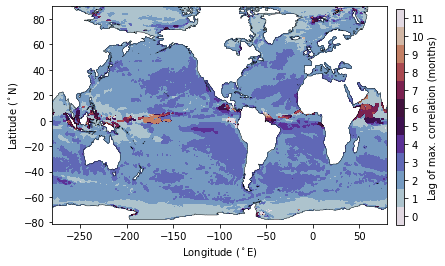

In [17]:
fig,ax = plt.subplots()
p1 = corr_lag2.idxmax('time').plot.contourf(cmap = 'twilight', levels = np.arange(13)-0.5, add_colorbar = False)
ax_cb = plt.axes([0.92,0.12,0.02,0.75])
cb = plt.colorbar(p1, cax = ax_cb, label = 'Lag of max. correlation (months)',ticks = np.arange(12))
mask.plot.contour(ax = ax, levels = [0.5],linewidths = 0.4, colors = 'k')

ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')


Text(0, 0.5, 'Latitude ($^\\circ$N)')

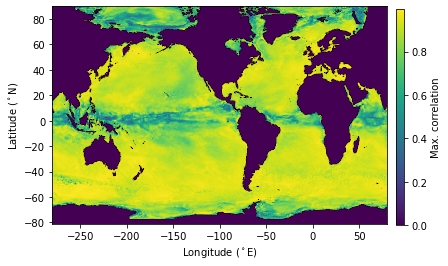

In [18]:
fig,ax = plt.subplots()
time = corr_lag2.idxmax('time')
p1 = corr_lag2.where(corr_lag2.time == time).sum('time').plot(add_colorbar = False)
ax_cb = plt.axes([0.92,0.12,0.02,0.75])
cb = plt.colorbar(p1, cax = ax_cb, label = 'Max. correlation')
mask.plot.contour(ax = ax, levels = [0.5],linewidths = 0.4, colors = 'k')

ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')


## Mixed Layer Depth

Text(0.5, 1.0, 'Max - min MLD')

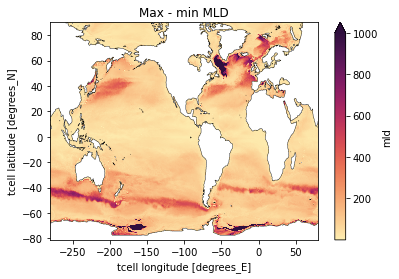

In [19]:
(fmonth_sc.mld.max('time')-fmonth_sc.mld.min('time')).plot(cmap = cm.cm.matter, vmax = 1000)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('Max - min MLD')

Text(0.5, 1.0, 'Max MLD')

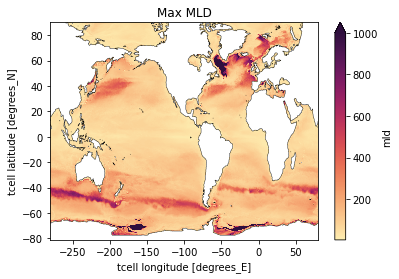

In [20]:
(fmonth_sc.mld.max('time')).plot(cmap = cm.cm.matter, vmax = 1000)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('Max MLD')

## Combined Plot

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


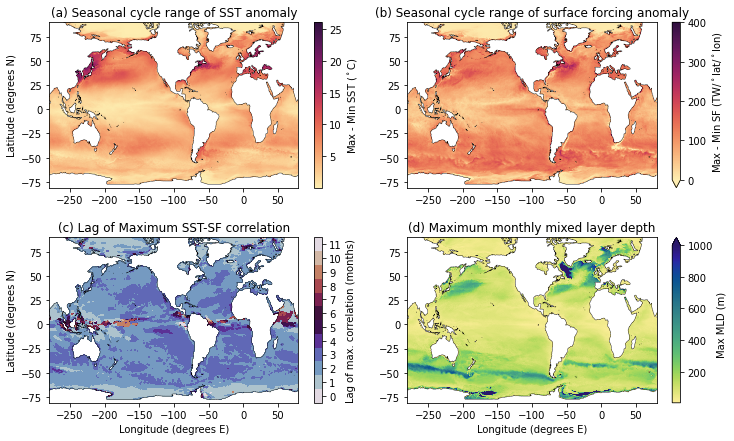

2022-10-28 23:52:33,866 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:33,869 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:33,904 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,037 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,039 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,085 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,137 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,189 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,276 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,284 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,362 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,417 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,420 - distributed.nanny - WARNING - Restarting worker
2022-10-28 23:52:34,423 - distributed.

In [22]:
fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize = (12,7))

## plot max - min SST over seasonal cycle
(fmonth_sc.temp.isel(st_ocean = 0).max('time')-fmonth_sc.temp.isel(st_ocean = 0).min('time')).plot(ax = axes[0,0],cmap = cm.cm.matter, cbar_kwargs = {'label':'Max - Min SST ($^\circ$C)'} )
mask.plot.contour(ax = axes[0,0],levels = [0.5],linewidths = 0.4, colors = 'k')

axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Latitude (degrees N)')
axes[0,0].set_title('(a) Seasonal cycle range of SST anomaly')

# plot max- min SF over seasonal cycle
temp = (fheat_sc.SF_cv.sum('st_ocean').max('time')-fheat_sc.SF_cv.sum('st_ocean').min('time')*fgrd.area_t/dxt/dyt/1e12)
temp.where(temp!=0).plot(ax = axes[0,1],cmap = cm.cm.matter, vmin = 0, vmax = 400, cbar_kwargs = {'label':'Max - Min SF (TW/$^\circ$lat/$^\circ$lon)'})
mask.plot.contour(ax = axes[0,1],levels = [0.5],linewidths = 0.4, colors = 'k')

axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_title('(b) Seasonal cycle range of surface forcing anomaly')

p1 = corr_lag2.idxmax('time').plot.contourf(ax = axes[1,0],cmap = 'twilight', levels = np.arange(13)-0.5, add_colorbar = False)
cb = plt.colorbar(p1, ax = axes[1,0], label = 'Lag of max. correlation (months)',ticks = np.arange(12))
mask.plot.contour(ax = axes[1,0], levels = [0.5],linewidths = 0.4, colors = 'k')

axes[1,0].set_xlabel('Longitude (degrees E)')
axes[1,0].set_ylabel('Latitude (degrees N)')
axes[1,0].set_title('(c) Lag of Maximum SST-SF correlation')
#axes[1,1].set_visible(False)

(fmonth_sc.mld.max('time')).plot(ax = axes[1,1],cmap = cm.cm.haline_r, vmax = 1000, cbar_kwargs = {'label':'Max MLD (m)'})
mask.plot.contour(ax = axes[1,1],levels = [0.5],linewidths = 0.4, colors = 'k')
axes[1,1].set_title('(d) Maximum monthly mixed layer depth')
axes[1,1].set_xlabel('Longitude (degrees E)')
axes[1,1].set_ylabel('')



fig.subplots_adjust(hspace = 0.3,wspace = 0.15)
fig.savefig('SST_SF_Corr.png',dpi = 200)